Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [76]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [17]:
train_labels[:]

array([0, 1, 4, ..., 1, 8, 2], dtype=int32)

In [10]:
np.arange(len(train_labels)) == train_labels[:, None]

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False]], dtype=bool)

In [77]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [67]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [78]:
def multilayer_perceptron(x, weights, biases):
     # Training computation.
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1_output = tf.nn.relu(layer_1)
    ## change data to relu
    
    logits = tf.matmul(layer_1_output, weights['h2']) + biases['b2']
    
    return logits


def regularization(weights):
    alpha = 0.007
    return alpha * sum(map(lambda w_i: tf.nn.l2_loss(w_i), weights.values()))


batch_size = 128

    # initial neoral network by train size @param batch_size
n_hidden = 1024
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
        tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
    
        weights = {
            'h1': tf.Variable(tf.truncated_normal([image_size * image_size, n_hidden])),
            'h2': tf.Variable(tf.truncated_normal([n_hidden, num_labels])),
            # output is num_labels
        }

        biases = {
            'b1': tf.Variable(tf.zeros([n_hidden])), # size equal to output nodess
            'b2': tf.Variable(tf.zeros([num_labels])), # size equal to output nodes
        }

        out_layer = multilayer_perceptron(tf_train_dataset, weights, biases)

        L = tf.nn.softmax_cross_entropy_with_logits(out_layer, tf_train_labels)
        L += regularization(weights)
        loss = tf.reduce_mean(L)

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(out_layer)
        valid_prediction = tf.nn.softmax(multilayer_perceptron(tf_valid_dataset, weights, biases))
        test_prediction = tf.nn.softmax(multilayer_perceptron(tf_test_dataset, weights, biases))

In [79]:
num_steps = 3001


# train this nn total is @param num_steps. 
with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2514.304688
Minibatch accuracy: 15.6%
Validation accuracy: 26.0%
Minibatch loss at step 500: 65.365730
Minibatch accuracy: 85.9%
Validation accuracy: 84.4%
Minibatch loss at step 1000: 2.665214
Minibatch accuracy: 84.4%
Validation accuracy: 84.4%
Minibatch loss at step 1500: 0.705578
Minibatch accuracy: 85.9%
Validation accuracy: 84.6%
Minibatch loss at step 2000: 0.753497
Minibatch accuracy: 79.7%
Validation accuracy: 84.5%
Minibatch loss at step 2500: 0.780378
Minibatch accuracy: 80.5%
Validation accuracy: 84.2%
Minibatch loss at step 3000: 0.795823
Minibatch accuracy: 81.2%
Validation accuracy: 84.3%
Test accuracy: 90.6%


> Result Analyse: The Test accuracy and validation accuracy are higher compared to no-regularization. 

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [95]:
def multilayer_perceptron(x, weights, biases):
     # Training computation.
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1_output = tf.nn.relu(layer_1)
    ## change data to relu
    
    logits = tf.matmul(layer_1_output, weights['h2']) + biases['b2']
    
    return logits


def regularization(weights):
    alpha = 0.007
    return alpha * sum(map(lambda w_i: tf.nn.l2_loss(w_i), weights.values()))


batch_size = 2

    # initial neoral network by train size @param batch_size
n_hidden = 1024
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
        tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
    
        weights = {
            'h1': tf.Variable(tf.truncated_normal([image_size * image_size, n_hidden])),
            'h2': tf.Variable(tf.truncated_normal([n_hidden, num_labels])),
            # output is num_labels
        }

        biases = {
            'b1': tf.Variable(tf.zeros([n_hidden])), # size equal to output nodess
            'b2': tf.Variable(tf.zeros([num_labels])), # size equal to output nodes
        }

        out_layer = multilayer_perceptron(tf_train_dataset, weights, biases)

        L = tf.nn.softmax_cross_entropy_with_logits(out_layer, tf_train_labels)
        L += regularization(weights)
        loss = tf.reduce_mean(L)

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(out_layer)
        valid_prediction = tf.nn.softmax(multilayer_perceptron(tf_valid_dataset, weights, biases))
        test_prediction = tf.nn.softmax(multilayer_perceptron(tf_test_dataset, weights, biases))
        

num_steps = 3001
# train this nn total is @param num_steps. 
with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
          print("Minibatch loss at step %d: %f" % (step, l))
          print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
          print("Validation accuracy: %.1f%%" % accuracy(
            valid_prediction.eval(), valid_labels))
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2494.298340
Minibatch accuracy: 50.0%
Validation accuracy: 10.0%
Minibatch loss at step 500: nan
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 1000: nan
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 1500: nan
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 2000: nan
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 2500: nan
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 3000: nan
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Test accuracy: 10.0%


> Result Analyse: Batch accuracy is still well, and its speed become quicker. But the validation accuracy is lower much more, and test accuracy also is lower much more. 

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [123]:
%%time 

def multilayer_perceptron(x, weights, biases):
     # Training computation.
    layer_1_output = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1_output = tf.nn.dropout(layer_1_output, keep_prob=.5, seed=0.)
    layer_1_output = tf.nn.relu(layer_1_output)


    ## change data to relu
    
    logits = tf.matmul(layer_1_output, weights['h2']) + biases['b2']
    
    return logits


def regularization(weights):
    alpha = 0.007
    return alpha * sum(map(lambda w_i: tf.nn.l2_loss(w_i), weights.values()))


batch_size = 256

    # initial neoral network by train size @param batch_size
n_hidden = 1024
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
        tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
    
        weights = {
            'h1': tf.Variable(tf.truncated_normal([image_size * image_size, n_hidden])),
            'h2': tf.Variable(tf.truncated_normal([n_hidden, num_labels])),
            # output is num_labels
        }

        biases = {
            'b1': tf.Variable(tf.zeros([n_hidden])), # size equal to output nodess
            'b2': tf.Variable(tf.zeros([num_labels])), # size equal to output nodes
        }

        out_layer = multilayer_perceptron(tf_train_dataset, weights, biases)

        L = tf.nn.softmax_cross_entropy_with_logits(out_layer, tf_train_labels)
        L += regularization(weights)
        loss = tf.reduce_mean(L)

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(out_layer)
        valid_prediction = tf.nn.softmax(multilayer_perceptron(tf_valid_dataset, weights, biases))
        test_prediction = tf.nn.softmax(multilayer_perceptron(tf_test_dataset, weights, biases))
        

num_steps = 3001
# train this nn total is @param num_steps. 
batch_accuracy = []
validation_accuracy = []
with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            b_accuracy = accuracy(predictions, batch_labels)
            batch_accuracy.append(b_accuracy)
            v_accuracy = accuracy(valid_prediction.eval(), valid_labels)
            validation_accuracy.append(v_accuracy)
            
            if(step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % b_accuracy)
                print("Validation accuracy: %.1f%%" % v_accuracy)
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2652.472412
Minibatch accuracy: 7.8%
Validation accuracy: 33.7%
Minibatch loss at step 500: 65.042114
Minibatch accuracy: 82.4%
Validation accuracy: 81.1%
Minibatch loss at step 1000: 2.668618
Minibatch accuracy: 85.2%
Validation accuracy: 83.6%
Minibatch loss at step 1500: 0.807773
Minibatch accuracy: 83.2%
Validation accuracy: 83.9%
Minibatch loss at step 2000: 0.642506
Minibatch accuracy: 85.2%
Validation accuracy: 84.3%
Minibatch loss at step 2500: 0.730790
Minibatch accuracy: 83.6%
Validation accuracy: 84.2%
Minibatch loss at step 3000: 0.785409
Minibatch accuracy: 78.9%
Validation accuracy: 83.8%
Test accuracy: 90.2%
CPU times: user 9min 6s, sys: 29.3 s, total: 9min 35s
Wall time: 2min 55s


In [121]:
### keep prob = 1.0, batch size = 256, time: 2min 59s
'''
%matplotlib inline
import matplotlib.pyplot as plt
X = [i * 50 for i in range(len(batch_accuracy))]
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')
'''

"\n%matplotlib inline\nimport matplotlib.pyplot as plt\nX = [i * 50 for i in range(len(batch_accuracy))]\nY1 = batch_accuracy\nY2 = validation_accuracy\n\nplt.plot(X, Y1, color='g')\nplt.plot(X, Y2, color='r')\n"

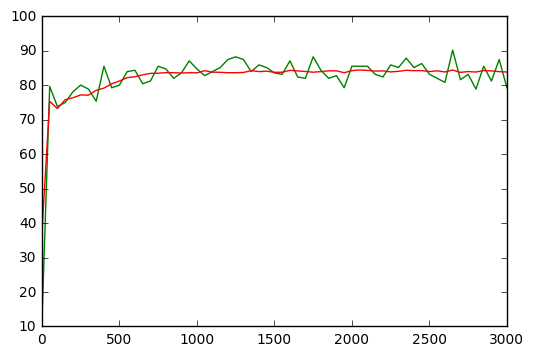

In [117]:
### keep prob = 0.5, batch size = 256
'''%matplotlib inline
import matplotlib.pyplot as plt
X = [i * 50 for i in range(len(batch_accuracy))]
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')
'''

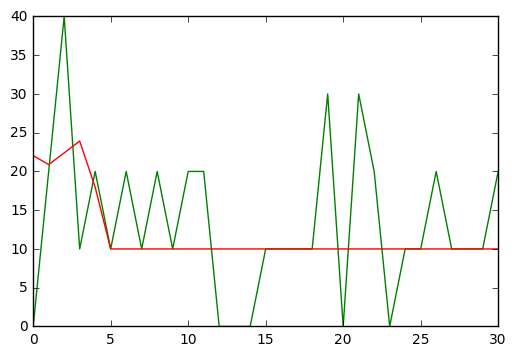

In [115]:
### keep prob = 0,5. batchs size = 10
'''%matplotlib inline
import matplotlib.pyplot as plt
X = list(range(len(batch_accuracy)))
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')
'''

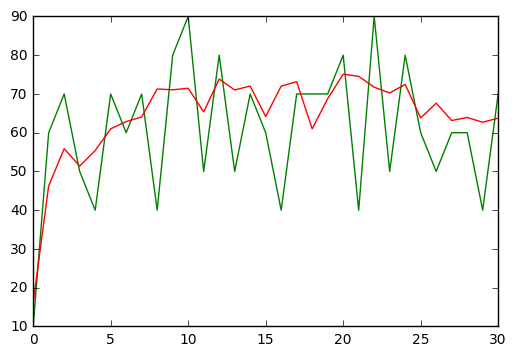

In [113]:
### keep prob = 1. batchs size = 10
'''
%matplotlib inline
import matplotlib.pyplot as plt
X = list(range(len(batch_accuracy)))
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')
'''

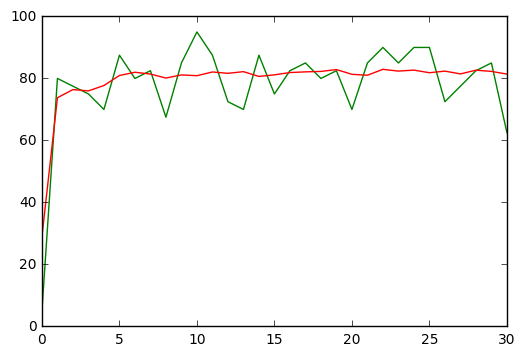

In [109]:
### keep prob = 1. batch size = 40
'''
%matplotlib inline
import matplotlib.pyplot as plt
X = list(range(len(batch_accuracy)))
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')
'''

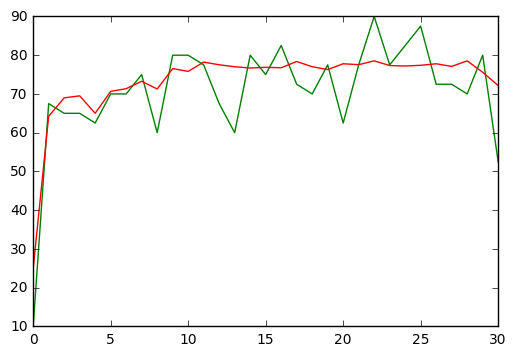

In [107]:
### keep prob == 0.6 batch size = 40
'''
%matplotlib inline
import matplotlib.pyplot as plt
X = list(range(len(batch_accuracy)))
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')
''''

### Result Recod: 
1. keep prob: 0.5, batch size: 10, test accuracy: 10.%
2. keep prob: 0.5, batch size: 128, test accuracy: 89.5%   time:  1min 28s
3. keep prob: 0.3, batch size: 128, test accuracy: 88.1%   time:  1min 24s
4. keep prob: 0.7, batch size: 128, test accuracy: 90.5%
    > validation accuracy is much higher that mini batch accuracy. 
5. keep prob: 0.8, **drop out before elue()** test accuracy: 90.3 %
6. keep prob: 0.6, batch size: 300, test accuracy: *90.7%* time: *2min 53s*
7. keep prob: 1. batch size: 300, test accuracy: *91.3%*, time: *2min44s*
8. keep prob: 0.6 batch size: 40, test accuracy: *85.2%*, time: *46.5s*
9. keep prob: 1. batch size: 40, test accuracy: *87.9%*, time: *46.5s*
    > Difference of batch accuracy: 92.5 => 81.8, 60.0 => 80.9
10. keep prob: 0.5 batch size: 40, test accuracy: *84.2*, time: *46.3*
    > Difference of batch accuracy: 82.5 => 76.9, 52.5 => 76.9



---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [132]:
%%time 

def multilayer_perceptron(x, weights, biases):
     # Training computation.
    layer_1_output = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
#    layer_1_output = tf.nn.dropout(layer_1_output, keep_prob=.5, seed=0.)
    layer_1_output = tf.nn.relu(layer_1_output)


    ## change data to relu
    
    logits = tf.matmul(layer_1_output, weights['h2']) + biases['b2']
    
    return logits


def regularization(weights):
    alpha = 0.007
    return alpha * sum(map(lambda w_i: tf.nn.l2_loss(w_i), weights.values()))


batch_size = 128

    # initial neoral network by train size @param batch_size
n_hidden = 1024
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
        tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
    
        weights = {
            'h1': tf.Variable(tf.truncated_normal([image_size * image_size, n_hidden])),
            'h2': tf.Variable(tf.truncated_normal([n_hidden, num_labels])),
            # output is num_labels
        }

        biases = {
            'b1': tf.Variable(tf.zeros([n_hidden])), # size equal to output nodess
            'b2': tf.Variable(tf.zeros([num_labels])), # size equal to output nodes
        }

        out_layer = multilayer_perceptron(tf_train_dataset, weights, biases)

        L = tf.nn.softmax_cross_entropy_with_logits(out_layer, tf_train_labels)
        L += regularization(weights)
        loss = tf.reduce_mean(L)

        # Optimizer.
        global_step = tf.Variable(0)
        starter_learning_rate = 0.1
        # decay_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
        learning_rate = tf.train.exponential_decay(0.1, global_step, 30001, 0.8)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(out_layer)
        valid_prediction = tf.nn.softmax(multilayer_perceptron(tf_valid_dataset, weights, biases))
        test_prediction = tf.nn.softmax(multilayer_perceptron(tf_test_dataset, weights, biases))
        

num_steps = 3500
# train this nn total is @param num_steps. 
batch_accuracy = []
validation_accuracy = []
with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            b_accuracy = accuracy(predictions, batch_labels)
            batch_accuracy.append(b_accuracy)
            v_accuracy = accuracy(valid_prediction.eval(), valid_labels)
            validation_accuracy.append(v_accuracy)
            
            if(step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % b_accuracy)
                print("Validation accuracy: %.1f%%" % v_accuracy)
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2588.015869
Minibatch accuracy: 11.7%
Validation accuracy: 25.2%
Minibatch loss at step 500: 1092.058472
Minibatch accuracy: 84.4%
Validation accuracy: 80.2%
Minibatch loss at step 1000: 541.906982
Minibatch accuracy: 85.2%
Validation accuracy: 82.2%
Minibatch loss at step 1500: 269.354279
Minibatch accuracy: 85.2%
Validation accuracy: 83.3%
Minibatch loss at step 2000: 134.933777
Minibatch accuracy: 85.9%
Validation accuracy: 85.1%
Minibatch loss at step 2500: 67.797173
Minibatch accuracy: 84.4%
Validation accuracy: 86.2%
Minibatch loss at step 3000: 34.518074
Minibatch accuracy: 85.2%
Validation accuracy: 87.0%
Test accuracy: 92.8%
CPU times: user 6min 6s, sys: 17.9 s, total: 6min 24s
Wall time: 2min
Parser   : 270 ms


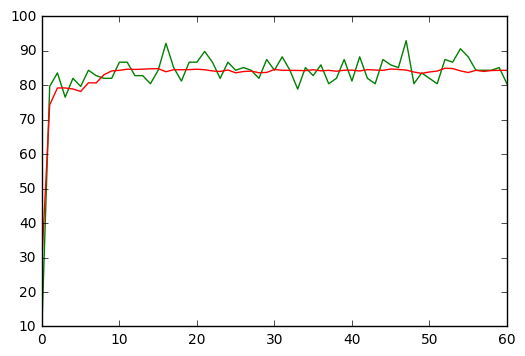

In [127]:
''' Start learnig rate = 0.1, decay rate = 0.96
%matplotlib inline
import matplotlib.pyplot as plt
X = list(range(len(batch_accuracy)))
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')
'''

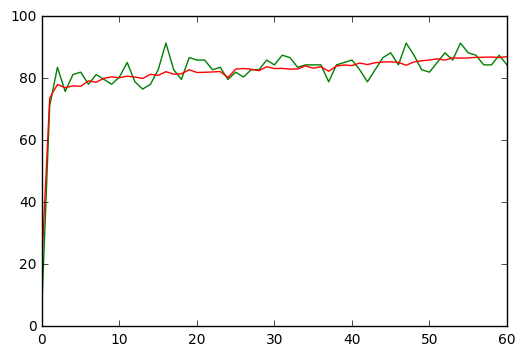

In [129]:
"""Start learning rate == 0.1, decay rate = 0.8"""
'''
%matplotlib inline
import matplotlib.pyplot as plt
X = list(range(len(batch_accuracy)))
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')
'''

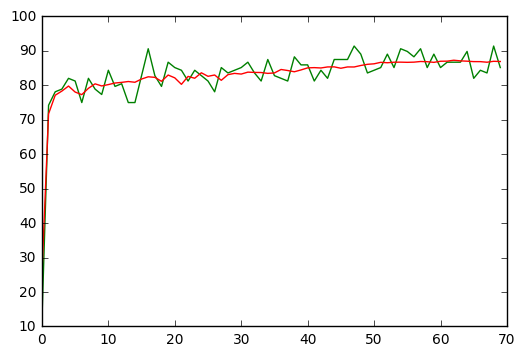

In [133]:
"""Start learning rate == 0.1, decay rate = 0.8 step = 3500"""

%matplotlib inline
import matplotlib.pyplot as plt
X = list(range(len(batch_accuracy)))
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')

In [157]:
%%time 

def multilayer_perceptron(x, weights, biases):
     # Training computation.
    layer_1_output = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1_output = tf.nn.dropout(layer_1_output, keep_prob=.5, seed=0.)
    layer_1_output = tf.nn.softsign(layer_1_output)
    
    layer_2_output = tf.add(tf.matmul(layer_1_output, weights['h2']), biases['b2'])
    layer_2_output = tf.nn.dropout(layer_2_output, keep_prob=.5, seed=0.)
    layer_2_output = tf.nn.softsign(layer_2_output)


    ## change data to relu
    
    logits = tf.matmul(layer_2_output, weights['h3']) + biases['b3']
    
    return logits


def regularization(weights):
    alpha = 0.007
    return alpha * sum(map(lambda w_i: tf.nn.l2_loss(w_i), weights.values()))


batch_size = 128

    # initial neoral network by train size @param batch_size
n_hidden = 1024
n2_hidden = 1024
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
        tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
    
        weights = {
            'h1': tf.Variable(tf.truncated_normal([image_size * image_size, n_hidden])),
            'h2': tf.Variable(tf.truncated_normal([n_hidden, n2_hidden])),
            'h3': tf.Variable(tf.truncated_normal([n2_hidden, num_labels]))
            # output is num_labels
        }

        biases = {
            'b1': tf.Variable(tf.zeros([n_hidden])), # size equal to output nodess
            'b2': tf.Variable(tf.zeros([n2_hidden])), # size equal to output nodes
            'b3': tf.Variable(tf.zeros([num_labels]))
        }

        out_layer = multilayer_perceptron(tf_train_dataset, weights, biases)

        L = tf.nn.softmax_cross_entropy_with_logits(out_layer, tf_train_labels)
        L += regularization(weights)
        loss = tf.reduce_mean(L)

        # Optimizer.
        global_step = tf.Variable(0)
        starter_learning_rate = 0.1
        # decay_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
        learning_rate = tf.train.exponential_decay(0.1, global_step, 30001, 0.7)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(out_layer)
        valid_prediction = tf.nn.softmax(multilayer_perceptron(tf_valid_dataset, weights, biases))
        test_prediction = tf.nn.softmax(multilayer_perceptron(tf_test_dataset, weights, biases))
        

num_steps = 10000
# train this nn total is @param num_steps. 
batch_accuracy = []
validation_accuracy = []
with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            b_accuracy = accuracy(predictions, batch_labels)
            batch_accuracy.append(b_accuracy)
            v_accuracy = accuracy(valid_prediction.eval(), valid_labels)
            validation_accuracy.append(v_accuracy)
            
            if(step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % b_accuracy)
                print("Validation accuracy: %.1f%%" % v_accuracy)
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 5070.764648
Minibatch accuracy: 10.9%
Validation accuracy: 10.4%
Minibatch loss at step 500: 2514.793945
Minibatch accuracy: 60.2%
Validation accuracy: 61.5%
Minibatch loss at step 1000: 1256.439331
Minibatch accuracy: 71.1%
Validation accuracy: 68.1%
Minibatch loss at step 1500: 630.023499
Minibatch accuracy: 69.5%
Validation accuracy: 71.0%
Minibatch loss at step 2000: 317.554596
Minibatch accuracy: 70.3%
Validation accuracy: 74.8%
Minibatch loss at step 2500: 160.754303
Minibatch accuracy: 79.7%
Validation accuracy: 77.9%
Minibatch loss at step 3000: 82.015488
Minibatch accuracy: 77.3%
Validation accuracy: 79.7%
Minibatch loss at step 3500: 41.982124
Minibatch accuracy: 82.8%
Validation accuracy: 81.2%
Minibatch loss at step 4000: 22.173775
Minibatch accuracy: 74.2%
Validation accuracy: 82.0%
Minibatch loss at step 4500: 11.411926
Minibatch accuracy: 91.4%
Validation accuracy: 82.8%
Minibatch loss at step 5000: 6.553178
Minibatch accuracy: 75.8%

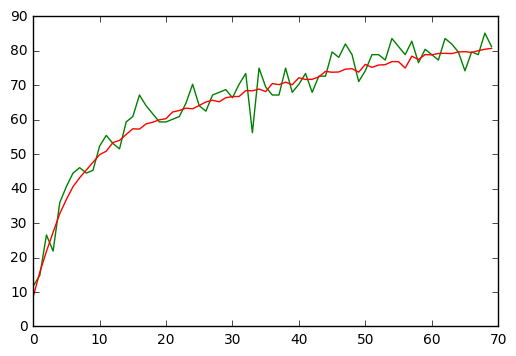

In [140]:
%matplotlib inline
'''Layer == 3 '''
'''
import matplotlib.pyplot as plt
X = [i * (num_steps / 50) for i in range(len(batch_accuracy))]
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')
'''

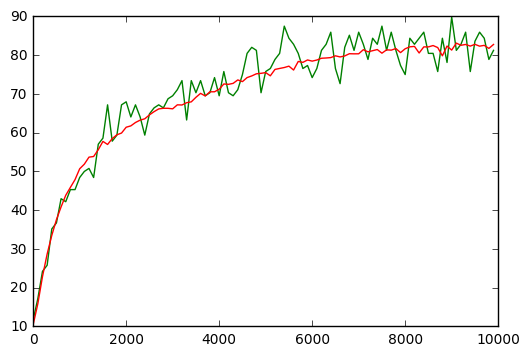

In [142]:
'''
X = [i * (num_steps / 50) for i in range(len(batch_accuracy))]
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')
'''

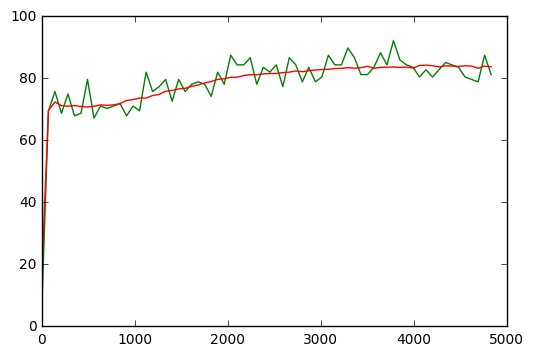

In [147]:
'''X = [i * (num_steps / 50) for i in range(len(batch_accuracy))]
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')
### Sigmoid and elue
'''

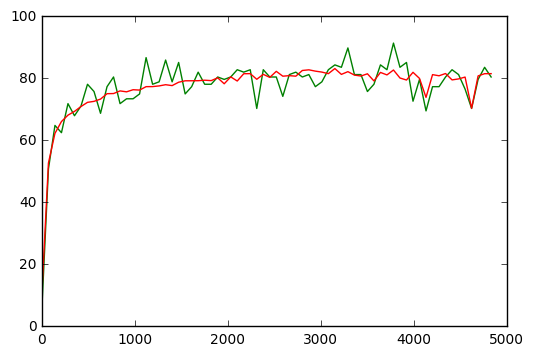

In [149]:
'''X = [i * (num_steps / 50) for i in range(len(batch_accuracy))]
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')
### Sigmoid and Sigmoid
'''

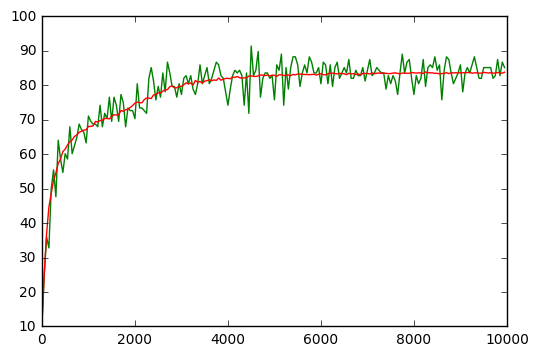

In [158]:
X = [i * 50 for i in range(len(batch_accuracy))]
Y1 = batch_accuracy
Y2 = validation_accuracy

plt.plot(X, Y1, color='g')
plt.plot(X, Y2, color='r')
### relu and elu